## Metric Calculations

In [194]:
from imports import (
    np, pd, xr, plt, os, LinearRegression,
    metrics, sys)

import fnmatch
from functions import regress_1d

%matplotlib inline

In [193]:
os.getcwd()

'/home/jonahks/git_repos/netcdf_analysis'

In [192]:
os.system('mountnird p/jonahks/') # mount the drive from NIRD, no working :(

32512

In [195]:
all_cases = os.listdir('/home/jonahks/drivemount/mnth15runs/')

case_dir = '/home/jonahks/drivemount/mnth15runs/'

In [196]:
all_cases

['20191127_162007_sampleparamset_wbf_0.01_inp_1',
 '20191124_194151_dud',
 '20191122_161009_sampleparamset_wbf_1_inp_1',
 '20191114_183930_sampleparamset_wbf_1_inp_10',
 '20191114_183930_sampleparamset_wbf_1_inp_1',
 '20191114_183930_sampleparamset_wbf_0.01_inp_1']

In [253]:
base_case = '20191122_161009_sampleparamset_wbf_1_inp_1'
cases = ['20191127_162007_sampleparamset_wbf_0.01_inp_1', '20191122_161009_sampleparamset_wbf_1_inp_1']

10,000 foot view of what I am trying to do

In [ ]:
test = create_base(base_case) # instantiate with the unmodified run
for case in cases:
    test.add_perturbation(case) # add the perturbations

test.performanalysis() # Plotting and calculating unit vectors, whatnot

In [198]:
os.path.exists(case_dir + base_case)
#base_case

True

In [199]:
def create_base(case_dir, origin): # pass the case name as a string, in this case base_case
    origin_ds = pd.read_csv('%s/%s_slf_caliop_comparison.csv' % (case_dir + origin, origin)).dropna() # open the .csv summary produced by jupy_test (RENAME)
    
    # Catch an annoying error
    try:
        origin_ds = origin_ds.set_index('Isotherm')
    except: pass    
    
    isos = np.array(origin_ds.index).reshape(-1,1)
    error = origin_ds['Arctic Error']
    # calculate the two parameters of interest, the error slope and the -20C isotherm error
    _r = regress_1d(isos, error)
#    _s = _r.score(isos, all_slf_clean[error])
    error_slope = _r.coef_
    
    plt.scatter(error, isos)
    
    error_20c = origin_ds.loc[[-20],['Arctic Error']] #, ["-20"]] 
    
    
    return origin_ds

,CALIOP_10N-10S,CALIOP_10S-30S,CALIOP_30N-10N,CALIOP_30S-50S,CALIOP_50N-30N,CALIOP_50S-70S,CALIOP_70N-50N,CALIOP_70S-90S,CALIOP_90N-70N,CALIOP Average,...,NorESM_10S-30S,NorESM_30N-10N,NorESM_30S-50S,NorESM_50N-30N,NorESM_50S-70S,NorESM_70N-50N,NorESM_70S-90S,NorESM_90N-70N,Arctic Error,Global Error
Isotherm,,,,,,,,,,,,,,,,,,,,,
-40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.649523,0.701112,0.734191,0.762072,0.910711,0.676523,1.686440,0.561619,0.561619,0.714611
-30.0,4.0,6.0,5.0,7.0,3.0,9.0,5.0,12.0,6.0,5.578054,...,5.272700,5.793299,6.189978,6.756526,12.026680,8.753282,14.389367,8.948410,2.948410,1.445471
-20.0,26.0,32.0,28.0,30.0,21.0,37.0,26.0,39.0,31.0,28.670216,...,11.964153,12.054469,15.180630,14.878921,28.873837,20.999265,25.780514,20.709251,-10.290749,-13.107442
-10.0,62.0,64.0,63.0,60.0,56.0,70.0,56.0,61.0,55.0,61.357769,...,30.198966,30.272848,42.999595,32.691968,50.902777,42.500702,44.331243,46.999692,-8.000308,-26.125227
0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.000000,...,87.985580,82.179623,92.512950,81.682527,86.840288,83.434027,58.937341,84.650561,-15.349439,-13.327181


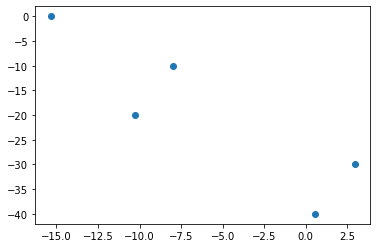

In [200]:
ds = create_base(case_dir, base_case)
ds

In [76]:
# retrieving two rows and three columns by loc method 
first = ds.loc[[-20],['Arctic Error']] #, ["-20"]] 
first

,Arctic Error
Isotherm,
-20,-10.290749


In [463]:
class SLF_Metric(object):
    
    def __init__(self, casedir):
        for cls in reversed(self.__class__.mro()):
            if hasattr(cls, 'init'):
                cls.init(self, casedir)

    def init(self, casedir):
        # Catch directory issues from the get-go
        if not os.path.exists(casedir):
            print('The case directory %s does not exist' % casedir)
#            sys.exit() # Is this a problem, does it need to be here?
            
        self.case_dir = casedir
        self.origin = None
        self.cases = {}

    def set_origin(self, case): # case is a string of the case name
        if case not in self.cases: # check if it is already in the dictionary
            self.add_case(case) 
        self.origin = self.cases[case] # should have a check for the object type
        
    def add_case(self, case): # Dictionary can be overwritten, should be fine
        
        self.cases[case] = SLF_case(self.case_dir, case) # Add an slf_case object to the cases dictionary
    
    def get_case(self, case):
        if case not in self.cases: # check if it is already in the dictionary
            print('Could not find %s in the SLF_Metric object' % case)
            return None
        else:
            return self.cases[case] # should have a check for the object type
    
    def get_cases(self):
        return self.cases
#        return list(self.cases.keys()) # This is a dict_keys object and should be an iterable
    
    def get_origin(self):
        return self.origin
    
    def plot(self):
        metric_plot = plt.figure(figsize=[10,10])

        origin = [self.origin.error_slope, self.origin.error_20c] # origin point (x,y)

        metric_cases = test.get_cases()
        for i in self.cases:
            _case = self.cases[i]
            # xy is the endpoint, xytext is the origin
            if not i == self.origin:
                oops = plt.scatter(_slope_error, _20c_error, label = str(i))
        #        color = oops.get_color()
        #        print(color)
                plt.annotate('', xy=(_case.error_slope, _case.error_20c), xytext=(origin[0], origin[1]), 
                            arrowprops=dict(facecolor='black', shrink=0., width=0.5, lw=1.0),
                            label = str(i))

        plt.scatter([origin[0]], [origin[1]], label = 'Initial Parametrization')
        plt.scatter([[0]], [[0]], color = 'black')
        plt.xlabel('Error Slope')
        plt.ylabel('"0C Isotherm SLF Error"')
        plt.grid()
        plt.legend()

        return metric_plot
    
class SLF_case:
    
    def __init__(self, casedir, case):
        self.case_dir = casedir # General directory where all cases are stored
        self.case = case # The origin case name (wbf = 1, slf = 1)
        self.case_ds = pd.read_csv('%s/%s_slf_caliop_comparison.csv' % (casedir + case, case)).dropna()
        
        # Catch an annoying error
        try:
            self.case_ds = self.case_ds.set_index('Isotherm')
        except: pass
        
#        self.date, self.time, self.paramfile, _, self.wbf_mult, _, self.inp_mult = self.case.split('_') # Parse string to get model parameters
        _temp_parsed = self.case.split('_') # Parse string to get model parameters
        self.date, self.time, self.paramfile = _temp_parsed[:3]
        self.wbf_mult = np.float(_temp_parsed[-3]); self.inp_mult = np.float(_temp_parsed[-1])
        self.isos = np.array(self.case_ds.index).reshape(-1,1)
        self.error = self.case_ds['Arctic Error']

        # calculate the two parameters of interest, the error slope and the -20C isotherm error
        self.error_20c = np.float(self.error.loc[[-20]]) # SLF error at the -20C isotherm (metric 2)        
        self.error_slope = np.float(regress_1d(self.isos, self.error).coef_)

In [464]:
test = SLF_Metric(case_dir)

In [465]:
test.add_case(base_case)
print(test.get_cases())
test.add_case(cases[0])
print(test.get_cases())
test2 = test.get_case(base_case)

{'20191122_161009_sampleparamset_wbf_1_inp_1': <__main__.SLF_case object at 0x7fa00a378748>}
{'20191122_161009_sampleparamset_wbf_1_inp_1': <__main__.SLF_case object at 0x7fa00a378748>, '20191127_162007_sampleparamset_wbf_0.01_inp_1': <__main__.SLF_case object at 0x7fa00a378d30>}


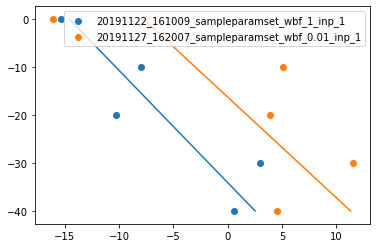

In [466]:
test_plt = plt.figure(1)
test_cases = test.get_cases()
case_names = list(test_cases.keys())
for j, i in enumerate(test_cases):
    case = test_cases[i]
    print(case)
#    plt.scatter(case.isos, case.error)
    plt.scatter(case.error, case.isos, label=str(i))
    _r = regress_1d(case.isos, case.error)
    plt.plot(_r.predict(case.isos), case.isos)
plt.legend()

#    _s = _r.score(isos, all_slf_clean[error])
#    f1_ax2.plot(_r.predict(isos), isos, color=color, label = ('$R^2 = %f$' % _s))

In [467]:
test.set_origin(case_names[0])
np.float(test.get_origin().error_slope)

-0.4277083447519167

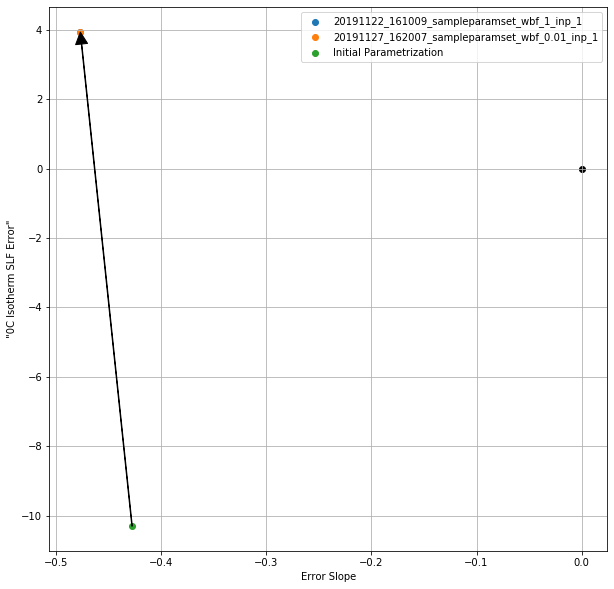

In [469]:
bob = test.plot()

[-0.4277083447519167, -10.290749029638297]
1.0 1.0
0.01 1.0


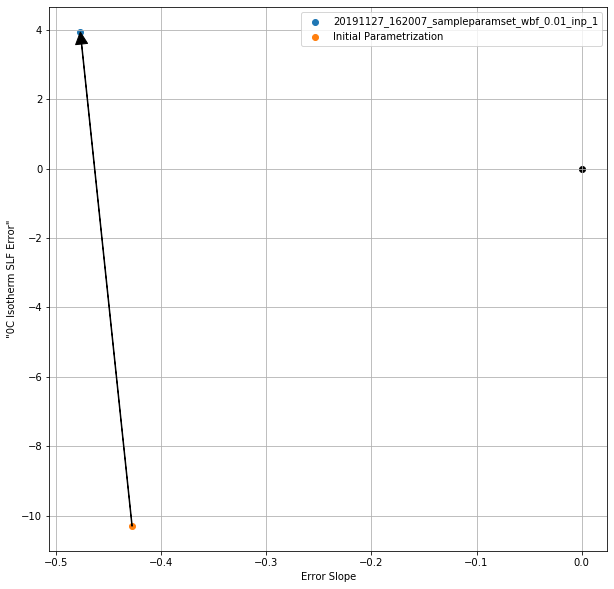

In [438]:
plt.figure(figsize=[10,10])

origin = [test.get_origin().error_slope, test.get_origin().error_20c] # origin point (x,y)
print(origin)
plt.figure(1)

metric_cases = test.get_cases()
for i in metric_cases:
    _case = metric_cases[i]
    print(_case.wbf_mult, _case.inp_mult)
    _20c_error, _slope_error = _case.error_20c, _case.error_slope
    # xy is the endpoint, xytext is the origin
    if not [_slope_error, _20c_error] == origin:
        oops = plt.scatter(_slope_error, _20c_error, label = str(i))
#        color = oops.get_color()
#        print(color)
        plt.annotate('', xy=(_slope_error, _20c_error), xytext=(origin[0], origin[1]), 
                    arrowprops=dict(facecolor='black', shrink=0., width=0.5, lw=1.0),
                    label = str(i))

plt.scatter([origin[0]], [origin[1]], label = 'Initial Parametrization')
plt.scatter([[0]], [[0]], color = 'black')
#plt.xlim((-0.5,0.5));
#plt.ylim((-15,5))
plt.xlabel('Error Slope')
plt.ylabel('"0C Isotherm SLF Error"')
plt.grid()
plt.legend()
plt.show()

1.0 1.0
0.0 0.0
0.01 1.0
-0.99 0.0


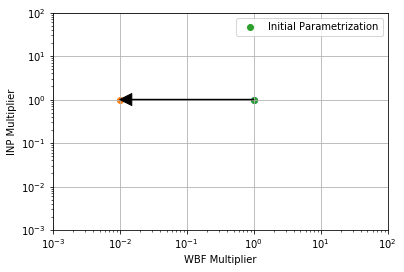

In [375]:
origin = [test.get_origin().wbf_mult, test.get_origin().inp_mult] # origin point (x,y)

plt.figure(1)
#plt.yscale('log')
#plt.xscale('log')

metric_cases = test.get_cases()
for i in metric_cases:
    _case = metric_cases[i]
    print(_case.wbf_mult, _case.inp_mult)
    _wbf, _inp = _case.wbf_mult, _case.inp_mult
    _dx = _wbf - origin[0]
    _dy = _inp - origin[1]
    print(_dx, _dy)
#    plt.quiver(*origin, _vec[:,0], _vec[:,1], scale=10)
#    plt.arrow(origin[0], origin[1], _dx, _dy, width = 0.02, head_width=0.1, head_length=0.1, label = 'doop %s' % str(i))

    # xy is the endpoint, xytext is the origin
    plt.annotate('', xy=(_wbf, _inp), xytext=(origin[0], origin[1]), 
                arrowprops=dict(facecolor='black', shrink=0., width=0.5, lw=1.0),
                )
    #    plt.quiver(_wbf, _inp, scale=15)
#    plt.scatter(*origin, _wbf, _inp, scale=15)
    plt.scatter(_wbf, _inp)

#plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], label=['wutt','is','this life'], scale=15)
#plt.scatter([0, 1], [0, 1])
plt.scatter([origin[0]], [origin[1]], label = 'Initial Parametrization')
plt.scatter([[0]], [[0]], color = 'black')
plt.xlim((1e-3,1e2));
plt.ylim((1e-3,1e2))
plt.xlabel('WBF Multiplier')
plt.ylabel('INP Multiplier')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

Text(2, 0.01, '')

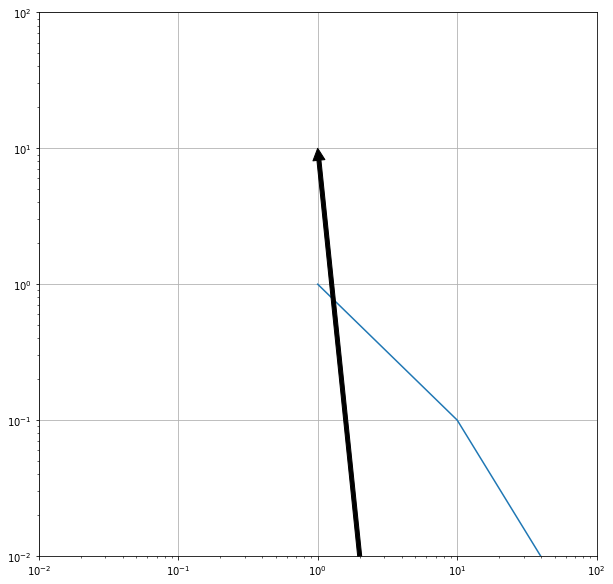

In [363]:
plt.figure(figsize=[10,10])
plt.loglog([1,10,60],[1,0.1,0.005])
plt.xlim(1e-2, 1e2)
plt.ylim(1e-2, 1e2)
plt.grid()

# xy is the endpoint, xytext is the origin
plt.annotate('', xy=(1, 10), xytext=(2, 0.01), 
            arrowprops=dict(facecolor='black', shrink=0.),
            )

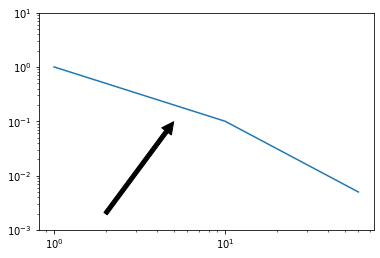

In [347]:
plt.annotate('', xy=(5, 0.098), xytext=(2, 0.002), 
            arrowprops=dict(facecolor='black', shrink=0.),
            )

plt.ylim(0.001, 10)

plt.show()

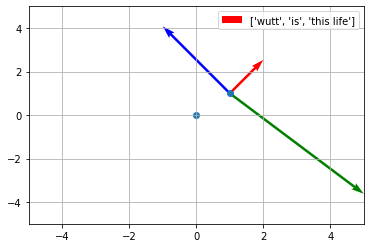

In [325]:
V = np.array([[1,1],[-2,2],[4,-3]])
origin = [test.get_origin().wbf_mult], [test.get_origin().inp_mult] # origin point (x,y)

plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], label=['wutt','is','this life'], scale=10)
plt.scatter([0, 1], [0, 1])
plt.xlim((-5,5));
plt.ylim((-5,5))
plt.grid()
plt.legend()
plt.show()

In [279]:
V[:,0], V[:,1]

(array([ 1, -2,  4]), array([ 1,  2, -7]))

Isotherm
-40.0     0.561619
-30.0     2.948410
-20.0   -10.290749
-10.0    -8.000308
 0.0    -15.349439
Name: Arctic Error, dtype: float64 [[-40.]
 [-30.]
 [-20.]
 [-10.]
 [  0.]]


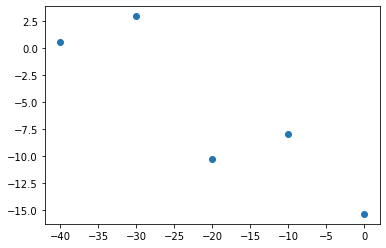

In [161]:
print(test2.error, test2.isos)
plt.scatter(test2.isos, test2.error)

In [81]:
d.value

'hello'

In [34]:
def parse_normally(casename):
    '''
    Parse a casename to recover run parameters and create an object associated with the output
    '''
    date, time, paramfile, _, wbf_mult, _, inp_mult = case.split('_')

    print('Case from %s at %s with %s WBF fraction and %s INP fraction' % (date, time, wbf_mult, inp_mult))
    print(casename)
    

In [23]:
    # Verify that the case directory exists and is where we expect it
    check = os.path.exists('%s%s' % (case_dir, casename))

    if check:
        return case_obj
    else:
        print('Could not find directory for %s in %s' % (casename, case_dir))
        sys.exit()
    return slf_run

In [35]:
for case in cases:
    parse_normally(case)

Case from 20191122 at 161009 with 1 WBF fraction and 1 INP fraction
20191122_161009_sampleparamset_wbf_1_inp_1
Case from 20191127 at 162007 with 0.01 WBF fraction and 1 INP fraction
20191127_162007_sampleparamset_wbf_0.01_inp_1
